
# Africa coverage map

Locations from R7/R8/R9 overlaid on Natural Earth admin boundaries from scratch.


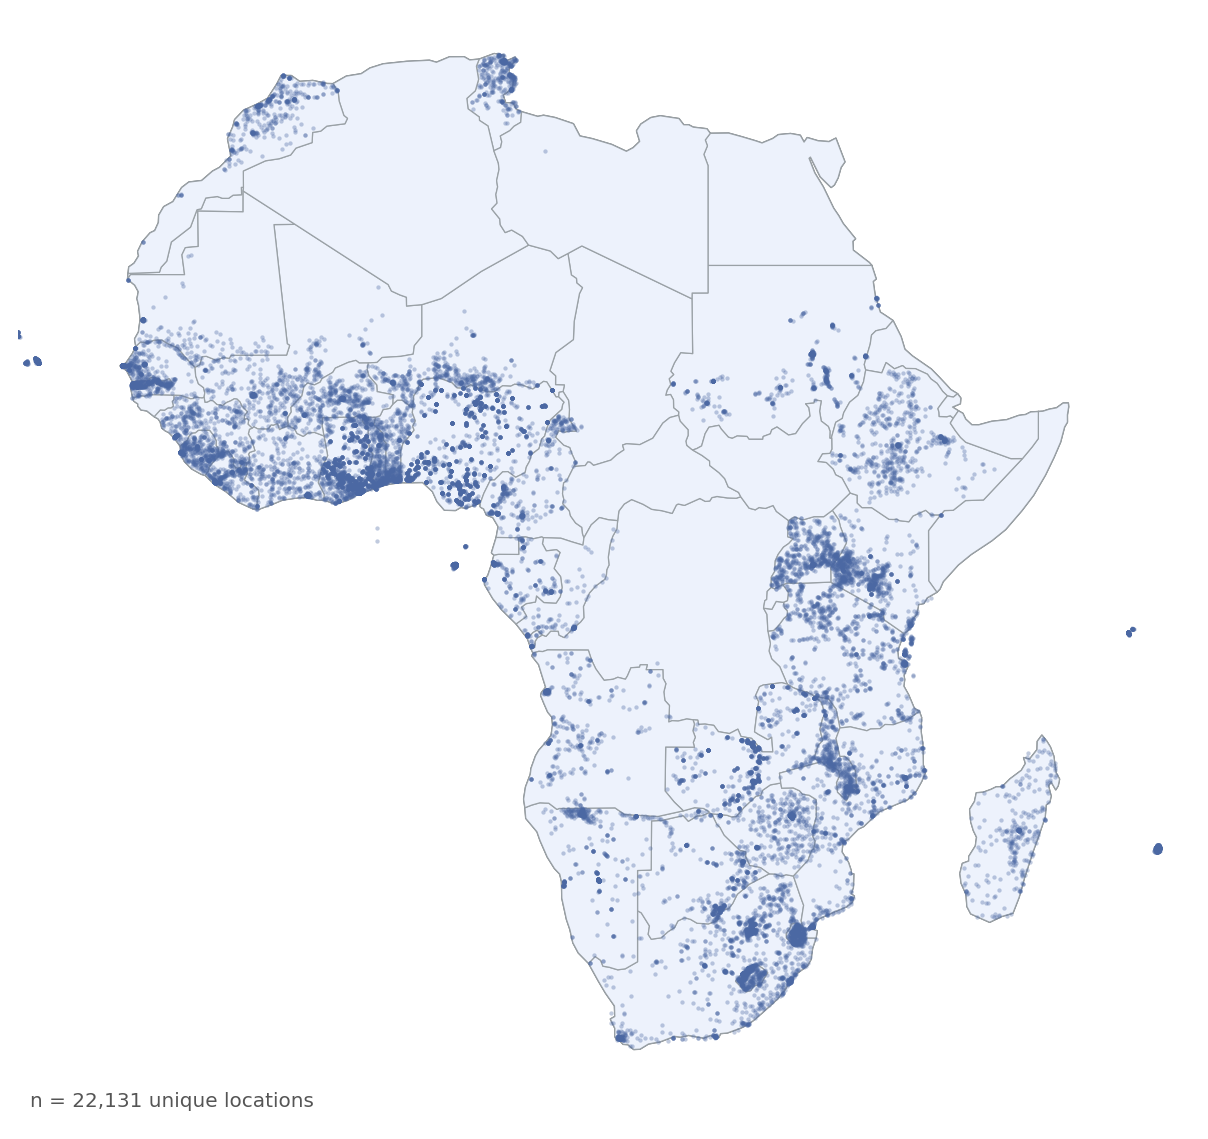

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path

# ----------------------------
# Data
# ----------------------------
csv_paths = [
    Path("/home/mila/e/echchabo/scratch/R7.csv"),
    Path("/home/mila/e/echchabo/scratch/R8.csv"),
    Path("/home/mila/e/echchabo/scratch/R9.csv"),
]
shapefile_path = Path(
    "/home/mila/e/echchabo/scratch/meta_pop_data/"
    "natural_earth_data/ne_110m_admin_0_countries.shp"
)

frames = [pd.read_csv(p, usecols=["EA_GPS_LA", "EA_GPS_LO"]) for p in csv_paths]
points = (
    pd.concat(frames, ignore_index=True)
    .rename(columns={"EA_GPS_LA": "lat", "EA_GPS_LO": "lon"})
    .dropna(subset=["lat", "lon"])
    .drop_duplicates()
)

world = gpd.read_file(shapefile_path)
africa = world[world["CONTINENT"] == "Africa"]

# ----------------------------
# Style (journal friendly)
# ----------------------------
mpl.rcParams.update({
    "font.family": "DejaVu Sans",
    "font.size": 9,
    "figure.dpi": 180,
    "savefig.dpi": 300,
})

xmin, xmax = -25, 60
ymin, ymax = -40, 40

# ----------------------------
# Plot
# ----------------------------
fig, ax = plt.subplots(figsize=(6.6, 6.6), constrained_layout=True)

# Light ocean background
ax.set_facecolor("#f4f6f8")

# Coastlines only (optional refinement)
africa.boundary.plot(
    ax=ax,
    linewidth=0.6,
    color="#8ec4e8",
    zorder=1
)

# Africa polygons (very subtle)
africa.plot(
    ax=ax,
    color="#edf2fc",
    edgecolor="#9aa1a6",
    linewidth=0.5,
    zorder=1
)

# Coverage points
ax.scatter(
    points["lon"],
    points["lat"],
    s=3.0,
    c="#4b68a3",        # muted academic red
    alpha=0.35,
    linewidth=0,
    rasterized=True,   # critical for clean PDFs
    zorder=2
)

# Map extent & aspect
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_aspect("equal", adjustable="box")

# Remove axes entirely
ax.axis("off")

# Title (minimal)
# ax.set_title(
#     "Spatial distribution of image coverage across Africa (R7–R9)",
#     pad=8
# )

# Optional: small annotation
ax.text(
    0.01, 0.01,
    f"n = {len(points):,} unique locations",
    transform=ax.transAxes,
    fontsize=8,
    color="#555555",
    ha="left",
    va="bottom"
)

# Export
# fig.savefig("africa_coverage_clean_scatter.pdf", bbox_inches="tight")
fig.savefig("africa_coverage_scatter.png", bbox_inches="tight")
plt.show()



## Country-level piped water map

Choropleth of piped water access by country using the summary CSV and the Natural Earth admin boundaries from scratch.


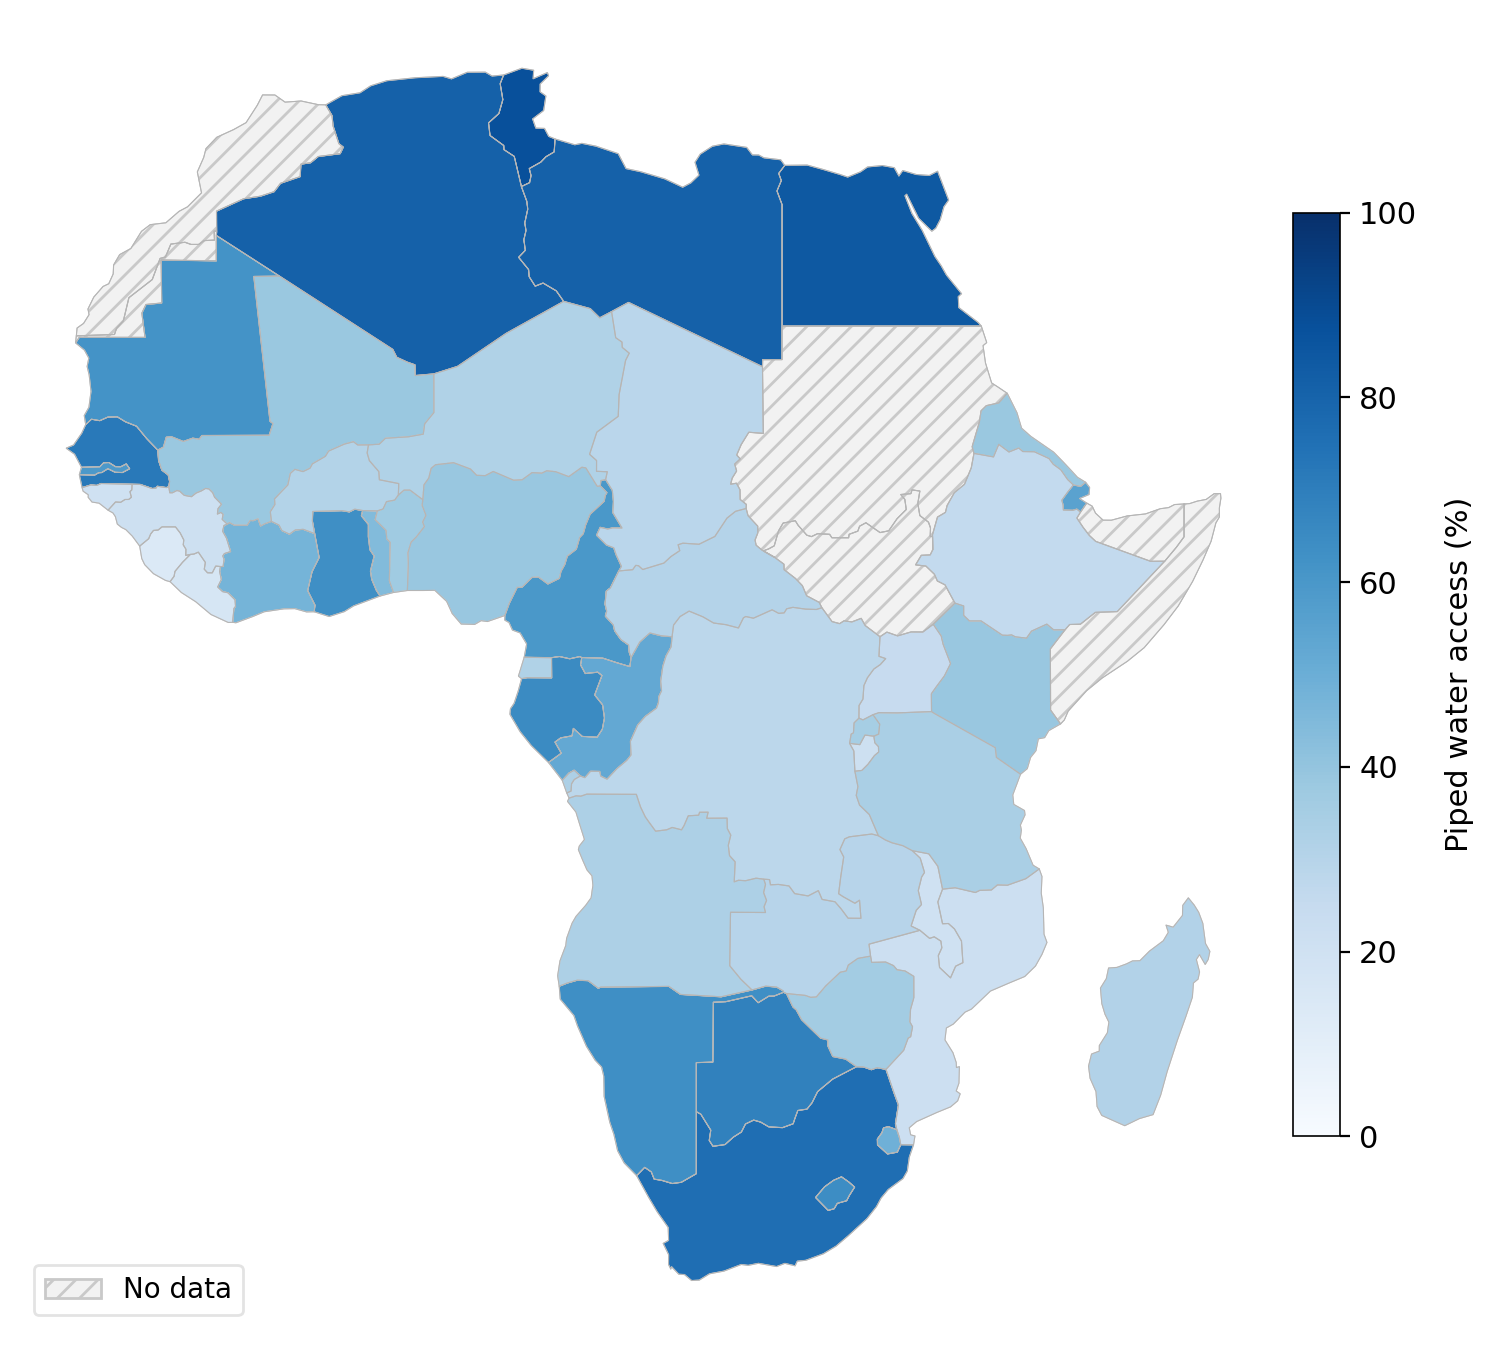

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib as mpl
from matplotlib.patches import Patch

# -----------------------------
# Paths
# -----------------------------
csv_path = Path("/home/mila/e/echchabo/scratch/meta_pop_data/countries_2x2/pipedwater_and_sewage_summary.csv")
shapefile_path = Path("/home/mila/e/echchabo/scratch/meta_pop_data/natural_earth_data/ne_110m_admin_0_countries.shp")

# -----------------------------
# Read + merge
# -----------------------------
df = pd.read_csv(csv_path)
df["name_key"] = df["Country"].str.strip().str.lower()

world = gpd.read_file(shapefile_path)
af = world[world["CONTINENT"] == "Africa"].copy()
af["name_key"] = af["NAME"].str.strip().str.lower()

# Make sure geometries are in lon/lat for consistent plotting
if af.crs is None:
    af = af.set_crs("EPSG:4326")
else:
    af = af.to_crs("EPSG:4326")

merged = af.merge(df, on="name_key", how="left")

# -----------------------------
# Style (paper-like)
# -----------------------------
plt.rcParams.update({
    "figure.dpi": 200,
    "savefig.dpi": 300,
    "font.size": 11,
    "axes.titlesize": 15,
    "axes.titleweight": "semibold",
})

# Choose a clean, colorblind-friendly cmap
cmap = plt.get_cmap("Blues")   # try also: "viridis"
vmin, vmax = 0, 100

fig, ax = plt.subplots(figsize=(7.6, 7.2))
fig.patch.set_facecolor("white")
ax.set_facecolor("white")

# 1) Base layer: light outlines for context
merged.plot(
    ax=ax,
    color="#F7F7F7",
    edgecolor="#D0D0D0",
    linewidth=0.35,
    zorder=1
)

# 2) Choropleth for available data
# Use a Normalize so the colorbar looks right
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

data_layer = merged.dropna(subset=["Piped Water Access (%)"])
data_layer.plot(
    ax=ax,
    column="Piped Water Access (%)",
    cmap=cmap,
    norm=norm,
    edgecolor="#E0E0E0",     # very light borders
    linewidth=0.30,
    zorder=2
)

# 3) Missing data layer (hatched, subtle)
missing_layer = merged[merged["Piped Water Access (%)"].isna()]
if len(missing_layer) > 0:
    missing_layer.plot(
        ax=ax,
        color="#F2F2F2",       # light fill
        edgecolor="#C9C9C9",
        linewidth=0.30,
        hatch="///",
        zorder=3
    )

# 4) Optional: outer coastline outline a touch darker (looks crisp)
merged.boundary.plot(ax=ax, color="#B5B5B5", linewidth=0.40, zorder=4)

# -----------------------------
# Clean axes + tight framing
# -----------------------------
ax.set_axis_off()

# Tight extent around Africa (with a small pad)
minx, miny, maxx, maxy = merged.total_bounds
padx = (maxx - minx) * 0.04
pady = (maxy - miny) * 0.04
ax.set_xlim(minx - padx, maxx + padx)
ax.set_ylim(miny - pady, maxy + pady)

# ax.set_title("Piped water access by country (R7–R9 summary)", pad=12)

# -----------------------------
# Colorbar (slim + nice)
# -----------------------------
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, fraction=0.035, pad=0.02)
cbar.set_label("Piped water access (%)", rotation=90, labelpad=10)
cbar.outline.set_linewidth(0.6)

# -----------------------------
# Small hatch legend (clean)
# -----------------------------
if len(missing_layer) > 0:
    hatch_patch = Patch(facecolor="#F2F2F2", edgecolor="#C9C9C9", hatch="///", label="No data")
    ax.legend(
        handles=[hatch_patch],
        loc="lower left",
        frameon=True,
        framealpha=0.9,
        facecolor="white",
        edgecolor="#E0E0E0",
        fontsize=10
    )

plt.tight_layout()
plt.show()

# For paper export:
fig.savefig("piped_water_africa.png", bbox_inches="tight", facecolor="white")
# fig.savefig("piped_water_africa.pdf", bbox_inches="tight", facecolor="white")


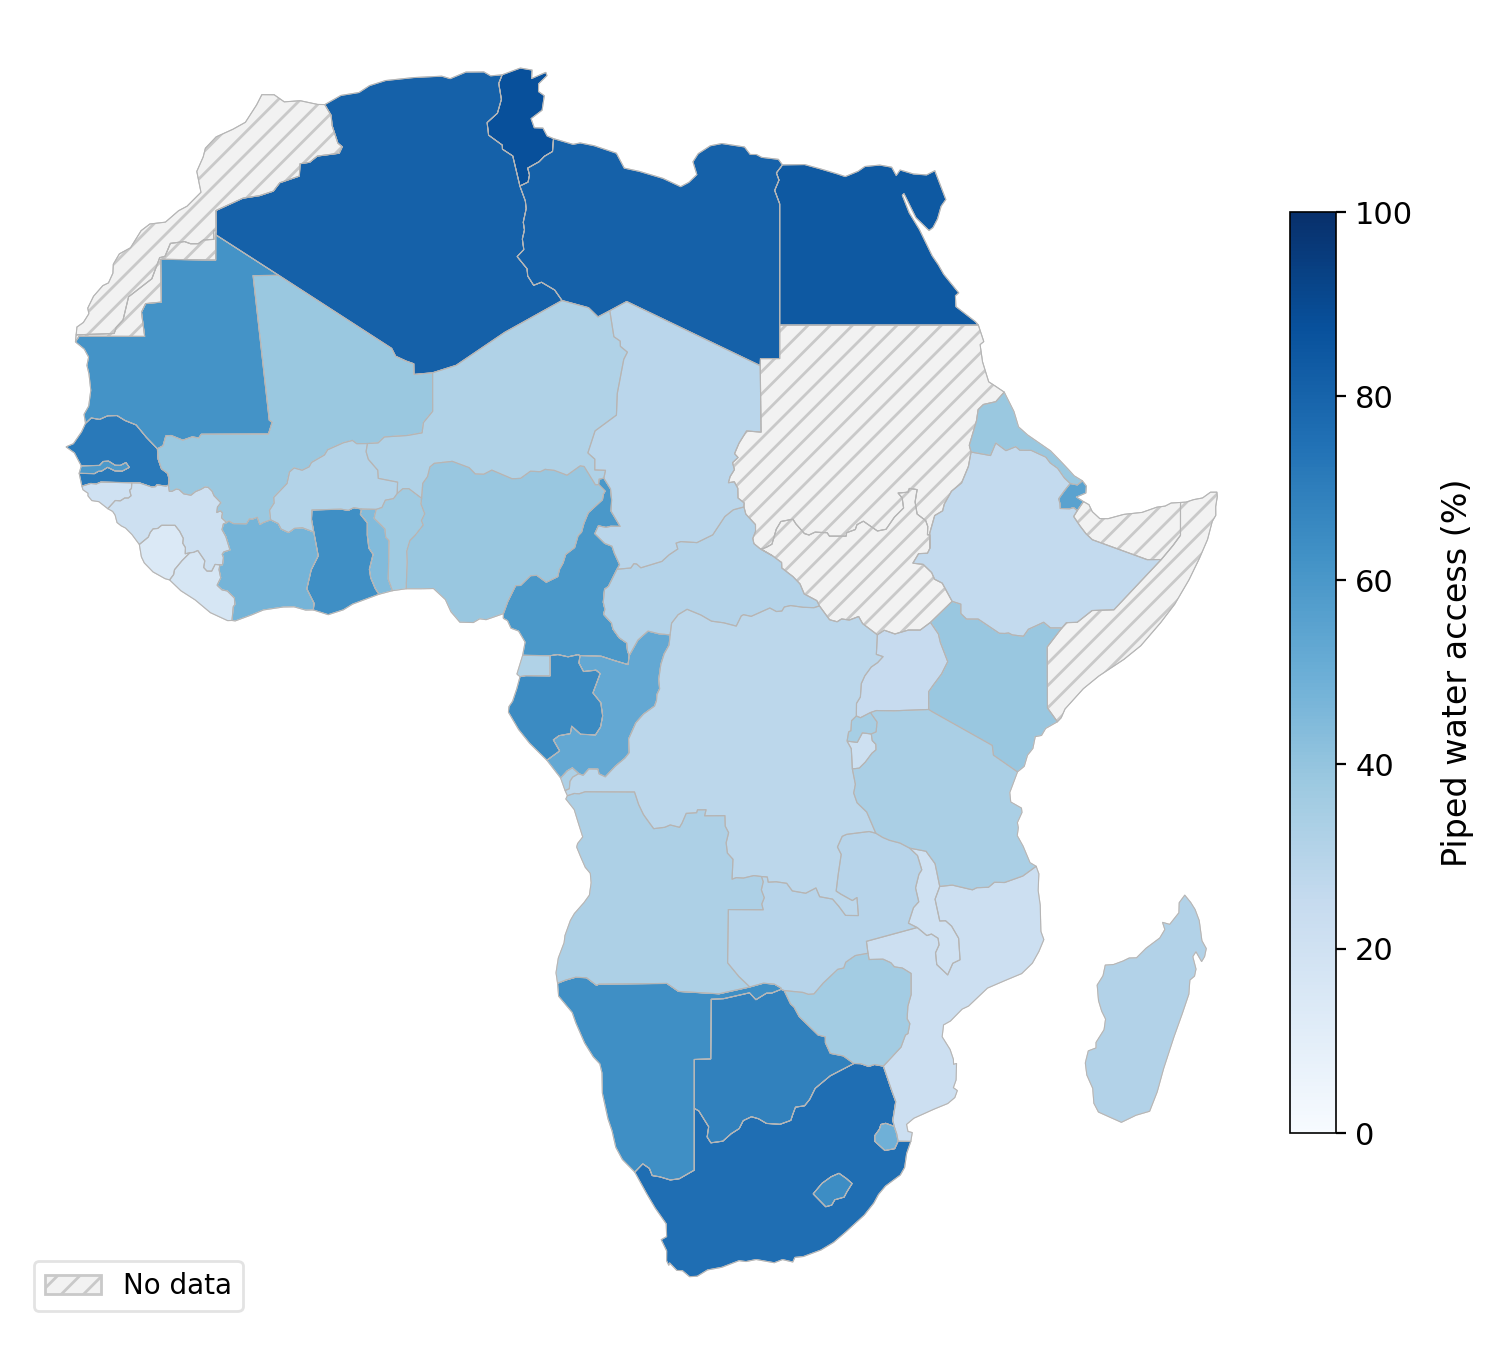

In [43]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib as mpl
from matplotlib.patches import Patch

# -----------------------------
# Paths
# -----------------------------
csv_path = Path("/home/mila/e/echchabo/scratch/meta_pop_data/countries_2x2/pipedwater_and_sewage_summary.csv")
shapefile_path = Path("/home/mila/e/echchabo/scratch/meta_pop_data/natural_earth_data/ne_110m_admin_0_countries.shp")

# -----------------------------
# Helpers
# -----------------------------
def make_name_key(s: pd.Series) -> pd.Series:
    return (
        s.astype(str)
         .str.strip()
         .str.lower()
         .str.replace(r"\s+", " ", regex=True)
    )

def fmt_pct(v):
    if pd.isna(v):
        return "NA"
    try:
        return f"{float(v):.0f}%"
    except Exception:
        return "NA"

def add_repelled_labels(
    fig,
    ax,
    gdf,
    text_col,
    fontsize=6.5,
    pad_px=1.5,
    candidates=None,
    arrow=False,
    force_place=True,
    max_labels=None,
):
    """
    Greedy label placement with overlap avoidance using display-space bboxes.

    - Places labels at representative_point() to ensure point is inside polygon.
    - Tries multiple pixel offsets around the anchor point; picks first non-overlapping.
    - If force_place=True, will place even if overlapping (last resort), so you still get *all* labels.
    """
    if candidates is None:
        # Offsets in points (matplotlib 'offset points' unit)
        candidates = [
            (0, 0),
            (8, 8), (8, -8), (-8, 8), (-8, -8),
            (14, 0), (-14, 0), (0, 14), (0, -14),
            (20, 10), (20, -10), (-20, 10), (-20, -10),
            (28, 0), (-28, 0), (0, 28), (0, -28),
        ]

    # Ensure we can measure text extents
    fig.canvas.draw()
    renderer = fig.canvas.get_renderer()

    # axes bbox in display coords (to keep labels within)
    ax_bb = ax.get_window_extent(renderer=renderer)
    occupied = []  # list of display-space bboxes already placed

    # Optionally limit number (debug)
    rows = gdf
    if max_labels is not None:
        rows = rows.head(max_labels)

    # Place biggest polygons first? Not necessary here; keep geographic-ish order.
    # But we can mildly stabilize by sorting by y then x in lon/lat.
    # We'll compute anchors first.
    anchors = rows.geometry.representative_point()
    rows = rows.copy()
    rows["_ax"] = anchors.x
    rows["_ay"] = anchors.y
    rows = rows.sort_values(["_ay", "_ax"], ascending=[False, True])  # north->south

    for _, r in rows.iterrows():
        name = str(r.get("NAME", "")).strip()
        txt = str(r.get(text_col, "")).strip()
        if not txt:
            continue

        x, y = float(r["_ax"]), float(r["_ay"])

        chosen = None
        chosen_meta = None

        # Try candidates and pick first that doesn't overlap
        for (dx, dy) in candidates:
            # Create temp text to measure bbox (must be annotate for xytext/textcoords)
            t = ax.annotate(
                txt,
                xy=(x, y),
                xytext=(dx, dy),
                textcoords="offset points",
                ha="left" if dx >= 0 else "right",
                va="bottom" if dy >= 0 else "top",
                fontsize=fontsize,
                bbox=dict(boxstyle="round,pad=0.16", fc="white", ec="0.80", alpha=0.82),
                zorder=10,
            )
            bb = t.get_window_extent(renderer=renderer).expanded(1.0, 1.0)
            t.remove()

            # pad bbox in pixels
            bb = bb.expanded(1.0 + pad_px / max(bb.width, 1), 1.0 + pad_px / max(bb.height, 1))

            # Keep inside axes box (soft constraint)
            inside = (
                bb.x0 >= ax_bb.x0 and bb.x1 <= ax_bb.x1 and
                bb.y0 >= ax_bb.y0 and bb.y1 <= ax_bb.y1
            )
            if not inside and (dx, dy) != (0, 0):
                continue

            # Overlap check against already-placed bboxes
            overlap = False
            for obb in occupied:
                if bb.overlaps(obb):
                    overlap = True
                    break

            if not overlap:
                chosen = (dx, dy)
                chosen_meta = bb
                break

        # If we couldn't find a free spot:
        if chosen is None:
            if not force_place:
                continue
            # Place anyway at (0,0) offset (or last candidate), accept overlaps.
            chosen = candidates[0]
            # measure for occupied bookkeeping
            t = ax.annotate(
                txt,
                xy=(x, y),
                xytext=chosen,
                textcoords="offset points",
                ha="left",
                va="bottom",
                fontsize=fontsize,
                bbox=dict(boxstyle="round,pad=0.16", fc="white", ec="0.80", alpha=0.75),
                zorder=10,
            )
            chosen_meta = t.get_window_extent(renderer=renderer)
            occupied.append(chosen_meta)
            # keep it (already added)
            continue

        # Commit chosen placement
        dx, dy = chosen
        ax.annotate(
            txt,
            xy=(x, y),
            xytext=(dx, dy),
            textcoords="offset points",
            ha="left" if dx >= 0 else "right",
            va="bottom" if dy >= 0 else "top",
            fontsize=fontsize,
            bbox=dict(boxstyle="round,pad=0.16", fc="white", ec="0.80", alpha=0.82),
            arrowprops=(dict(arrowstyle="-", color="0.55", lw=0.6, alpha=0.7) if arrow else None),
            zorder=10,
        )
        occupied.append(chosen_meta)

# -----------------------------
# Read + merge
# -----------------------------
df = pd.read_csv(csv_path)

# normalize keys
df["name_key"] = make_name_key(df["Country"])

world = gpd.read_file(shapefile_path)
af = world[world["CONTINENT"] == "Africa"].copy()
af["name_key"] = make_name_key(af["NAME"])

# Ensure lon/lat
if af.crs is None:
    af = af.set_crs("EPSG:4326")
else:
    af = af.to_crs("EPSG:4326")

merged = af.merge(df, on="name_key", how="left")

# If your column name differs, change it here:
VALUE_COL = "Piped Water Access (%)"

# Make numeric for plotting
if VALUE_COL in merged.columns:
    merged[VALUE_COL] = pd.to_numeric(merged[VALUE_COL], errors="coerce")

# Create label text: "Country 72%"
merged["label_text"] = merged.apply(
    lambda r: f"{r['NAME']} {fmt_pct(r.get(VALUE_COL))}",
    axis=1
)

# -----------------------------
# Style (paper-like)
# -----------------------------
plt.rcParams.update({
    "figure.dpi": 200,
    "savefig.dpi": 300,
    "font.size": 11,
    "axes.titlesize": 15,
    "axes.titleweight": "semibold",
})

cmap = plt.get_cmap("Blues")
vmin, vmax = 0, 100
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

fig, ax = plt.subplots(figsize=(7.6, 7.2))
fig.patch.set_facecolor("white")
ax.set_facecolor("white")

# 1) Base layer: light outlines for context
merged.plot(
    ax=ax,
    color="#F7F7F7",
    edgecolor="#D0D0D0",
    linewidth=0.35,
    zorder=1
)

# 2) Choropleth for available data
data_layer = merged.dropna(subset=[VALUE_COL]) if VALUE_COL in merged.columns else merged.iloc[0:0]
if len(data_layer) > 0:
    data_layer.plot(
        ax=ax,
        column=VALUE_COL,
        cmap=cmap,
        norm=norm,
        edgecolor="#E0E0E0",
        linewidth=0.30,
        zorder=2
    )

# 3) Missing data layer (hatched, subtle)
missing_layer = merged[merged[VALUE_COL].isna()] if VALUE_COL in merged.columns else merged
if len(missing_layer) > 0:
    missing_layer.plot(
        ax=ax,
        color="#F2F2F2",
        edgecolor="#C9C9C9",
        linewidth=0.30,
        hatch="///",
        zorder=3
    )

# 4) Optional: coastline outline
merged.boundary.plot(ax=ax, color="#B5B5B5", linewidth=0.40, zorder=4)

# -----------------------------
# Clean axes + tight framing
# -----------------------------
ax.set_axis_off()

minx, miny, maxx, maxy = merged.total_bounds
padx = (maxx - minx) * 0.04
pady = (maxy - miny) * 0.04
ax.set_xlim(minx - padx, maxx + padx)
ax.set_ylim(miny - pady, maxy + pady)

# -----------------------------
# Colorbar
# -----------------------------
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, fraction=0.035, pad=0.02)
cbar.set_label("Piped water access (%)", rotation=90, labelpad=10)
cbar.outline.set_linewidth(0.6)

# -----------------------------
# Hatch legend
# -----------------------------
if len(missing_layer) > 0:
    hatch_patch = Patch(facecolor="#F2F2F2", edgecolor="#C9C9C9", hatch="///", label="No data")
    ax.legend(
        handles=[hatch_patch],
        loc="lower left",
        frameon=True,
        framealpha=0.9,
        facecolor="white",
        edgecolor="#E0E0E0",
        fontsize=10
    )

# -----------------------------
# Labels (ALL countries + percentage), with overlap avoidance
# -----------------------------
# NOTE: labeling *all* countries will still be dense at 110m resolution.
# This places everything, and tries to minimize overlaps; if no free spot, it still places.
# add_repelled_labels(
#     fig,
#     ax,
#     merged,
#     text_col="label_text",
#     fontsize=6.2,     # tweak (5.5–7.0)
#     pad_px=1.5,
#     arrow=False,      # arrows get messy on dense maps; set True if you want
#     force_place=True
# )

plt.tight_layout()

# For paper export:
fig.savefig("piped_water_africa.png", bbox_inches="tight", facecolor="white")
# fig.savefig("piped_water_africa.pdf", bbox_inches="tight", facecolor="white")

plt.show()


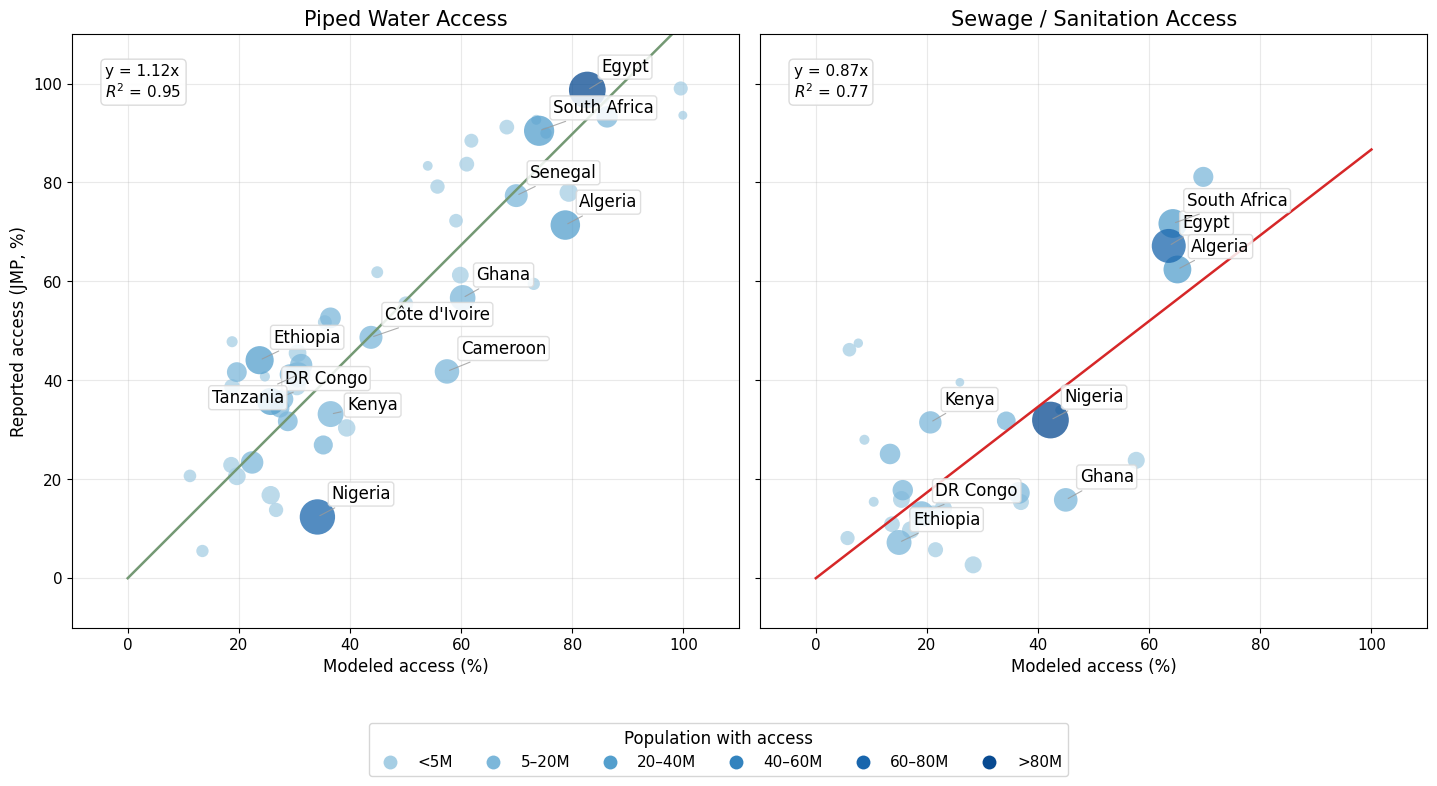

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# --------------------
# Style
# --------------------
plt.rcParams.update({
    "font.family": "DejaVu Sans",
    "font.size": 11,
    "axes.titlesize": 15,
    "axes.labelsize": 12,
    "legend.title_fontsize": 12,
    "legend.fontsize": 11,
})

# --------------------
# Load data
# --------------------
water = pd.read_csv("africa_water_access.csv")
sew = pd.read_csv("africa_sewage_access.csv", encoding="latin1")

# numeric conversion
for col in ["Piped Water Access (%)", "Piped (JMP)", "Piped Water Access"]:
    if col in water.columns:
        water[col] = pd.to_numeric(water[col], errors="coerce")

for col in ["Sewage Access (%)", "Sum", "Sewage Access", "Safely managed"]:
    if col in sew.columns:
        sew[col] = pd.to_numeric(sew[col], errors="coerce")

# drop missing
water = water.dropna(subset=["Piped Water Access (%)", "Piped (JMP)", "Piped Water Access"])
sew = sew.dropna(subset=["Sewage Access (%)", "Safely managed", "Sewage Access"])

# --------------------
# Regression helpers
# --------------------
def fit_through_origin(x, y):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    return (x @ y) / (x @ x)

def r2_uncentered(x, y, m):
    y_hat = m * x
    return 1 - np.sum((y - y_hat) ** 2) / np.sum(y ** 2)

def bubble_sizes(pop, min_s=18, max_s=700):
    z = np.sqrt(pop / np.nanmax(pop))
    return min_s + z * (max_s - min_s)

# --------------------
# Population bins + colors (single source of truth)
# --------------------
bins = [0, 5e6, 20e6, 40e6, 60e6, 80e6, np.inf]
labels = ["<5M", "5–20M", "20–40M", "40–60M", "60–80M", ">80M"]
colors = plt.cm.Blues(np.linspace(0.35, 0.9, len(labels)))

def pop_bin_index(pop):
    return np.digitize(pop, bins[1:-1], right=False)

# --------------------
# Repelled label helper
# --------------------
def _bboxes_overlap(bb1, bb2, pad_px=2):
    """bb1, bb2 are matplotlib.transforms.Bbox in display coords."""
    bb1 = bb1.expanded(1.0, 1.0)
    bb2 = bb2.expanded(1.0, 1.0)
    bb1 = bb1.from_extents(bb1.x0 - pad_px, bb1.y0 - pad_px, bb1.x1 + pad_px, bb1.y1 + pad_px)
    bb2 = bb2.from_extents(bb2.x0 - pad_px, bb2.y0 - pad_px, bb2.x1 + pad_px, bb2.y1 + pad_px)
    return bb1.overlaps(bb2)

def annotate_big_countries_repel(
    fig, ax, df,
    xcol, ycol, popcol,
    country_col="Country",
    top_n=12,
    min_pop=None,
    fontsize=12,
    pad_px=2,
    arrow=True,
):
    """
    Place labels using ax.annotate with offset points.
    Tries many candidate offsets and picks the first non-overlapping placement
    (based on already-placed label bounding boxes in display/pixel coords).
    """
    if country_col not in df.columns:
        return

    d = df[[country_col, xcol, ycol, popcol]].dropna().copy()

    if min_pop is not None:
        d = d[d[popcol] >= min_pop]

    if top_n is not None:
        d = d.sort_values(popcol, ascending=False).head(top_n)

    # biggest first
    d = d.sort_values(popcol, ascending=False)

    # ensure we have a renderer & updated transforms
    fig.canvas.draw()
    renderer = fig.canvas.get_renderer()

    placed_bboxes = []

    # offsets in *points* (screen space); try near -> farther
    candidates = [
        (10, 10), (12, 0), (0, 12), (-10, 10),
        (10, -10), (-10, -10), (-12, 0), (0, -12),
        (18, 12), (18, -12), (-18, 12), (-18, -12),
        (28, 16), (28, -16), (-28, 16), (-28, -16),
        (40, 0), (-40, 0), (0, 40), (0, -40),
    ]

    # keep labels inside axes area somewhat (in display coords)
    axbb = ax.get_window_extent(renderer=renderer)

    for _, row in d.iterrows():
        name = str(row[country_col])
        x = float(row[xcol])
        y = float(row[ycol])

        # skip if point is outside current view
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        if not (xlim[0] <= x <= xlim[1] and ylim[0] <= y <= ylim[1]):
            continue

        chosen = None
        chosen_bb = None
        chosen_ha = "left"
        chosen_va = "bottom"

        for (dx, dy) in candidates:
            ha = "left" if dx >= 0 else "right"
            va = "bottom" if dy >= 0 else "top"

            # Create a temporary annotate to measure bbox
            t = ax.annotate(
                name,
                xy=(x, y),
                xytext=(dx, dy),
                textcoords="offset points",
                ha=ha, va=va,
                fontsize=fontsize,
                bbox=dict(boxstyle="round,pad=0.18", fc="white", ec="0.85", alpha=0.85),
                zorder=6,
            )
            bb = t.get_window_extent(renderer=renderer)
            t.remove()

            # Keep label mostly within axes bbox
            if (bb.x0 < axbb.x0) or (bb.x1 > axbb.x1) or (bb.y0 < axbb.y0) or (bb.y1 > axbb.y1):
                continue

            # Check overlaps
            if any(_bboxes_overlap(bb, prev, pad_px=pad_px) for prev in placed_bboxes):
                continue

            chosen = (dx, dy)
            chosen_bb = bb
            chosen_ha, chosen_va = ha, va
            break

        # If nothing worked, fall back to a default offset (still place it)
        if chosen is None:
            chosen = (10, 10)
            chosen_ha, chosen_va = "left", "bottom"

        ax.annotate(
            name,
            xy=(x, y),
            xytext=chosen,
            textcoords="offset points",
            ha=chosen_ha, va=chosen_va,
            fontsize=fontsize,
            bbox=dict(boxstyle="round,pad=0.18", fc="white", ec="0.85", alpha=0.85),
            arrowprops=(dict(arrowstyle="-", color="0.6", lw=0.8, alpha=0.8) if arrow else None),
            zorder=6,
        )

        # update placed bbox list (re-measure final one)
        fig.canvas.draw()
        renderer = fig.canvas.get_renderer()
        # measure bbox of last added text: easiest is to re-measure all and take the newest
        # but we can just create a temporary invisible measurement at same position:
        t2 = ax.annotate(
            name,
            xy=(x, y),
            xytext=chosen,
            textcoords="offset points",
            ha=chosen_ha, va=chosen_va,
            fontsize=fontsize,
            bbox=dict(boxstyle="round,pad=0.18", fc="white", ec="0.85", alpha=0.85),
            alpha=0.0,
        )
        bb2 = t2.get_window_extent(renderer=renderer)
        t2.remove()
        placed_bboxes.append(bb2)

# --------------------
# Figure
# --------------------
fig, axes = plt.subplots(1, 2, figsize=(14.5, 7.6), sharex=True, sharey=True)
xfit = np.linspace(0, 100, 200)
xpad, ypad = 10, 10

# ====================
# Piped water
# ====================
x = water["Piped Water Access (%)"].to_numpy()
y = water["Piped (JMP)"].to_numpy()
pop = water["Piped Water Access"].to_numpy()

m = fit_through_origin(x, y)
r2 = r2_uncentered(x, y, m)

idx = pop_bin_index(pop)
sizes = bubble_sizes(pop)

for i in range(len(labels)):
    mask = idx == i
    axes[0].scatter(
        x[mask], y[mask],
        s=sizes[mask],
        color=colors[i],
        alpha=0.75,
        edgecolors="none",
    )

axes[0].plot(xfit, m * xfit, color="#749974", linewidth=1.8)

axes[0].text(
    0.05, 0.95,
    f"y = {m:.2f}x\n$R^2$ = {r2:.2f}",
    transform=axes[0].transAxes,
    ha="left", va="top",
    bbox=dict(boxstyle="round", fc="white", ec="0.85", alpha=0.95),
)

axes[0].set_title("Piped Water Access")
axes[0].set_xlabel("Modeled access (%)")
axes[0].set_ylabel("Reported access (JMP, %)")

# ====================
# Sewage
# ====================
x = sew["Sewage Access (%)"].to_numpy()
y = sew["Safely managed"].to_numpy()
pop = sew["Sewage Access"].to_numpy()

m2 = fit_through_origin(x, y)
r22 = r2_uncentered(x, y, m2)

idx2 = pop_bin_index(pop)
sizes2 = bubble_sizes(pop)

for i in range(len(labels)):
    mask = idx2 == i
    axes[1].scatter(
        x[mask], y[mask],
        s=sizes2[mask],
        color=colors[i],
        alpha=0.75,
        edgecolors="none",
    )

axes[1].plot(xfit, m2 * xfit, color="tab:red", linewidth=1.8)

axes[1].text(
    0.05, 0.95,
    f"y = {m2:.2f}x\n$R^2$ = {r22:.2f}",
    transform=axes[1].transAxes,
    ha="left", va="top",
    bbox=dict(boxstyle="round", fc="white", ec="0.85", alpha=0.95),
)

axes[1].set_title("Sewage / Sanitation Access")
axes[1].set_xlabel("Modeled access (%)")

# --------------------
# Shared styling (set limits BEFORE label repel)
# --------------------
for ax in axes:
    ax.set_xlim(-xpad, 100 + xpad)
    ax.set_ylim(-ypad, 100 + ypad)
    ax.grid(alpha=0.28)
    ax.set_axisbelow(True)

# --------------------
# Repelled labels (do AFTER axes limits are set)
# --------------------
annotate_big_countries_repel(
    fig, axes[0],
    water,
    xcol="Piped Water Access (%)",
    ycol="Piped (JMP)",
    popcol="Piped Water Access",
    country_col="Country",
    top_n=12,
    min_pop=10e6,   # try 30e6 or 40e6 if you want fewer labels
    fontsize=12,
    pad_px=2,
    arrow=True,
)

annotate_big_countries_repel(
    fig, axes[1],
    sew,
    xcol="Sewage Access (%)",
    ycol="Safely managed",
    popcol="Sewage Access",
    country_col="Country",
    top_n=12,
    min_pop=10e6,
    fontsize=12,
    pad_px=2,
    arrow=True,
)

# --------------------
# Legend (same colors as scatter)
# --------------------
legend_elements = [
    Line2D(
        [0], [0],
        marker="o", linestyle="",
        label=labels[i],
        markerfacecolor=colors[i],
        markeredgecolor="none",
        markersize=10
    )
    for i in range(len(labels))
]

fig.legend(
    handles=legend_elements,
    title="Population with access",
    loc="lower center",
    ncol=len(labels),
    frameon=True,
    bbox_to_anchor=(0.5, -0.04),
    columnspacing=1.6,
)

plt.tight_layout(rect=[0, 0.08, 1, 1])
plt.savefig("water_sewage_access_comparison.png", bbox_inches="tight", dpi=300)
plt.show()
